## Questão 2: Perceptron Backpropagation 

## Problema


## Ideia


## Características do dados

//TODO

## Geração atomática de dados

//TODO

In [233]:
import statistics as st
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Funções de Ativação

Foram implementadas funções básicas de ativação para serem opções no uso na rede.

In [179]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

def degrau(x, derivative=False):
    if derivative:
        np.where(x>0.5,1,1)
    return np.where(x>0.5,1,0)

def step(x,derivative=False):
    if derivative:
        return np.where(x>0,1,1)
    return np.where(x>0,1,0)

## Função de Custo

In [231]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

## Classe Layer

A classe Layer representa uma layer da rede guardando a entrada da camada, pesos, biases, função de ativação e saída da camada.

### Parâmetros

- __input_dim__: dimensão dos dados de entrada da camada
- ___units___: quantidade de neurônios da camada
- __activation__: função de ativação que será utilizada nos neurônios da rede

### Atributos

- __input__: dados de entrada da camada
- __weights__: matriz todos os pesos de todos os neutônios da camada
- __biases__: vetor com os valores dos bias de todos os neurônios da camada
- __activation__: função de ativação que será utilizada nos neurônios da rede
- __activ_out__: guarda os valores resultantes da função de ativação



In [185]:
class Layer:
    def __init__(self, input_dim, output_dim, activation=degrau, use_bias=True):
        self.input = None
        self.weights = np.random.randn(output_dim, input_dim)
        self.biases = np.random.randn(1, output_dim)
        self.activation = activation
        self._activ_inp, self._activ_out = None, None
        self.input_dim = input_dim
        self.use_bias = use_bias
        self.dweights, self.dbias = None, None

## Classe NeuralNetwork

A classe representa a Rede Neural, na caso o Perceptron.

### Atributos

- __layers__: conjunto de layers da rede


In [229]:
class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        
    def fit(self, x, y, x_valid, y_valid, batch_size=1, epochs=100, verbose=10):
        '''
            Função de treinamento
            Parâmetros:
                x - entradas
                y - saídas esperadas
                learning_rate - taxa de aprendizagem
                epochs - quantidade de épocas de treinamento
                verbose - passos para verificação da época
        '''
        errors_train = []
        errors_valid = []
        batch_count = 0
        
        for epoch in range(epochs+1):
            error_epoch = []
            for x_i, y_i in zip(x, y):
                
                x_i =  x_i.reshape(1, x.shape[1])
                y_pred = self.__feedforward(x_i)
                
                batch_count += 1
                
                erro = y_i - y_pred
                error_epoch.append(st.median(erro[0]))
                
                if not batch_count%batch_size:
                    self.__backpropagation(y_i, y_pred)
            
            # calculo do erro de predição
            y_pred = self.prediction(x_valid)
            acc = accuracy_score(y_valid, y_pred)
            errors_valid.append(1 - acc)
            errors_train.append(st.median(error_epoch))
            
            if epoch % verbose == 0:
                cost = self.cost_func(y_i, y_pred)
                print("epoch: {0:=4}/{1}\nerror: {2}".format(epoch, epochs, st.median(error_epoch)))
            
        return errors_train, errors_valid
    
    def add_layer(self, layer):
        '''
            Método para adição de layers ao modelo
            Parâmetros:
                layer - Layer a se adicionada ao modelo
        '''
        self.layers.append(layer)
    
    def __feedforward(self, x):
        '''
            Método de Feedforward - Efetua a multiplicação das entradas pelos pesos, soma ao bias, aplica função de ativação
            Parâmetros:
                x - dados de entrada
        '''
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:]+[Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out
    
    def prediction(self, x):
        '''
            Método de Predição - Gera um conjunto de valores resultante do processo de FeedForward nos para os dados de entrada
            Parâmetros:
                x - dados de entrada
        '''
        y_pred = []
        
        for data in x:
            pred = self.__feedforward(data)

            for p in pred:
                pred = p
                break
    
            y_pred.append(pred)
            
        return np.array(y_pred)
    
    def evaluate(self,y_pred, y, dtype=int):
        '''
            Método Evaluate - Verifica a accuracy da rede
            Parâmetros:
                y_pred - resultado do processo de FeedForward sobre os dados de entrada
                dtype - tipo dos dados
        '''
        score = 0

        for y_i, y_pred_i in zip(y,y_pred):
            if np.equal(np.argmax(y_i),np.argmax(y_pred_i[0])):
                score+=1
                
        return score/y.shape[0]

    def __backpropagation(self, y,y_pred):
            last_delta = self.cost_func(y, y_pred, derivative=True)
            for layer in reversed(self.layers):
                dactivation = layer.activation(layer._activ_inp, derivative=True)*last_delta
                last_delta = np.dot(dactivation, layer.weights)
                layer.dweights = np.dot(dactivation.T, layer.input)
                layer.dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)

            for layer in reversed(self.layers):
                layer.weights = layer.weights - self.learning_rate*layer.dweights
                layer.biases = layer.biases - self.learning_rate*layer.dbiases

## Execução

__1__ - A rede é inicializada

__2__ - Os dados de entrada e saida são obtidos

__3__ - Treinamento é feito com 80% dos dados e o Teste com os 20% restantes

__4__ - Accuracy da rede é verificada

## Arquitetura Usada

//TODO

## Parâmetros utilizados

//TODO

In [211]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('./data_x.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('./data_y.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

## 2 a) Treinamento Estocástico

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 2

- __Layer1__:
 - Dimensão de Entrada: 3
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Layer2__:
 - Dimensão de Entrada: 8
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Treinamento__:
 - Épocas: 100


epoch:    0/100
error: 0.0
epoch:   50/100
error: 0.0
epoch:  100/100
error: 0.0


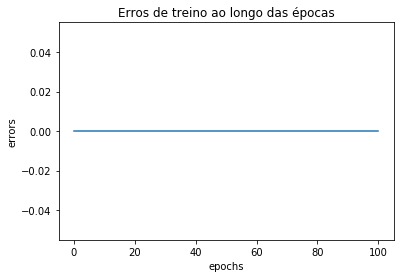

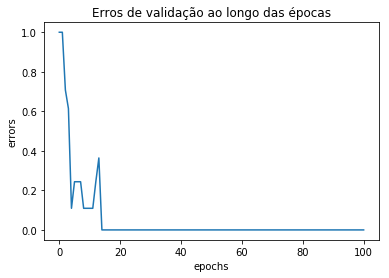

1.0


In [230]:
nn = NeuralNetwork(learning_rate=0.001)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=step))
nn.add_layer(Layer(input_dim=8, output_dim=8, activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, epochs=100, verbose=50)

plt.title("Erros de treino ao longo das épocas")
plt.xlabel("epochs")
plt.ylabel("errors")
plt.plot(errors_train)
plt.show()

plt.title("Erros de validação ao longo das épocas")
plt.xlabel("epochs")
plt.ylabel("errors")
plt.plot(errors_valid)
plt.show()

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred.round())

print(acc)

## 2 b) Treinamento com Batch

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 2

- __Layer1__:
 - Dimensão de Entrada: 3
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Layer2__:
 - Dimensão de Entrada: 8
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Treinamento__:
 - Batch: 5
 - Épocas: 200

epoch:    0/200
error: 0.0
epoch:   50/200
error: 0.0
epoch:  100/200
error: 0.0
epoch:  150/200
error: 0.0
epoch:  200/200
error: 0.0


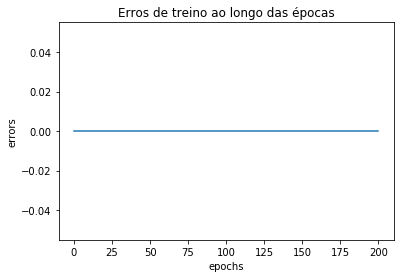

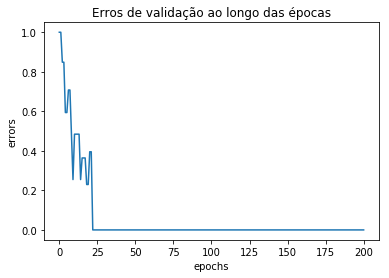

1.0


In [220]:
nn = NeuralNetwork(learning_rate=0.001)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=step))
nn.add_layer(Layer(input_dim=8, output_dim=8, activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, batch_size=5, epochs=200, verbose=50)

plt.title("Erros de treino ao longo das épocas")
plt.xlabel("epochs")
plt.ylabel("errors")
plt.plot(errors_train)
plt.show()

plt.title("Erros de validação ao longo das épocas")
plt.xlabel("epochs")
plt.ylabel("errors")
plt.plot(errors_valid)
plt.show()

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred.round())

print(acc)